In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot
from Scaling import time_scaling, time_inv_scaling

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


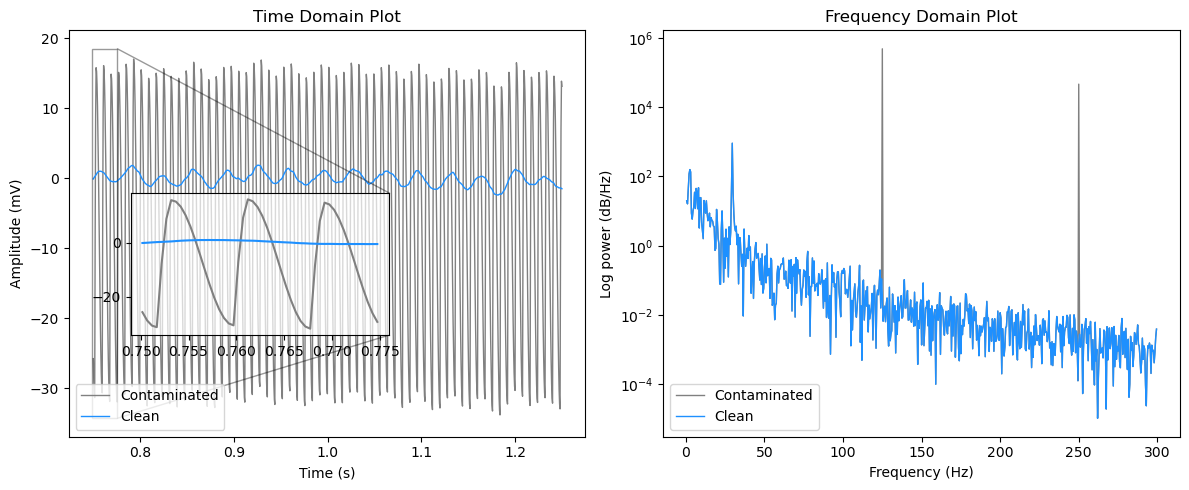

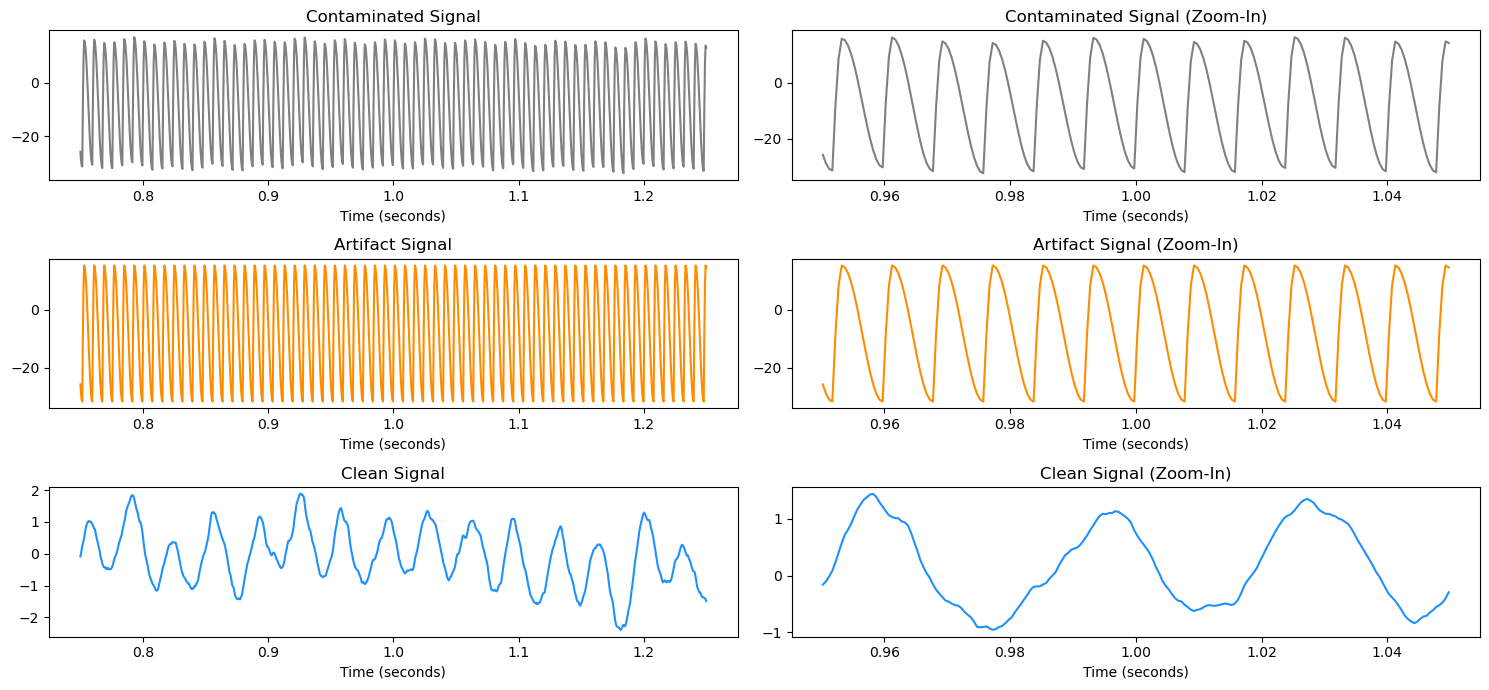

In [7]:
# 데이터 load & plot
datapath='../../data/synthetic_data/1000_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [8]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [9]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1]) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

#train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
#test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

#train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 1, 4000)
y_train shape: (800, 1, 4000)
-----------------------------
X_test shape: (200, 1, 4000)
y_test shape: (200, 1, 4000)
-----------------------------


In [10]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_dim=16, kernel_size=3, dropout_rate=0.25):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_dim, kernel_size, padding=1),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size, padding=1),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.GELU(),
            nn.Conv1d(hidden_dim * 2, hidden_dim, kernel_size, padding=1),
            nn.GELU(),
            nn.Conv1d(hidden_dim, out_channels, kernel_size, padding=1)
        )
        
        self.drop = nn.Dropout1d(dropout_rate)

    def forward(self, x):  # x: B x 1 x T
        x = self.layer1(x)
        return x

model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# 학습 함수 정의
def train_model(config, X_train, y_train, X_test, y_test):
    # 모델 초기화
    model = CNN(
        in_channels=config["in_channels"],
        out_channels=config["out_channels"],
        hidden_dim=config["hidden_dim"],
        kernel_size=config["kernel_size"],
        dropout_rate=config["dropout_rate"]
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    # 학습 루프
    for epoch in range(10):  # 에폭 수를 고정
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        print("Shape:", outputs.shape, y_train.shape)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    
    # 평가
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
    
    # 성능 지표 반환
    return {"loss": val_loss.item()}


In [18]:

# Ray Tune에서 사용할 하이퍼파라미터 검색 공간 정의
config = {
    "in_channels": tune.choice([1]),
    "out_channels": tune.choice([1]),
    "hidden_dim": tune.choice([16, 32, 64]),
    "kernel_size": tune.choice([3, 5]),
    "dropout_rate": tune.uniform(0.2, 0.5),
    "lr": tune.loguniform(1e-4, 1e-2)
}

# 학습 및 검증 데이터를 텐서로 변환하여 GPU에 업로드
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print(f"X_train shape: {X_train_tensor.shape}\ny_train shape: {y_train_tensor.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test_tensor.shape}\ny_test shape: {y_test_tensor.shape}")
print("-----------------------------")

# ASHA 스케줄러를 사용하여 효율적인 하이퍼파라미터 탐색
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)

import os
os.environ["RAY_TMPDIR"] = "C:/ray_tmp"

# 경로 길이를 줄이기 위한 trial_dirname_creator 설정
def trial_name_creator(trial):
    return f"trial_{trial.trial_id}"

# Ray Tune 실행
result = tune.run(
    tune.with_parameters(train_model, X_train=X_train_tensor, y_train=y_train_tensor, X_test=X_test_tensor, y_test=y_test_tensor),
    resources_per_trial={"cpu": 2, "gpu": 1},  # CPU와 GPU 자원 설정
    config=config,
    num_samples=100,  # 샘플링할 설정 수
    scheduler=scheduler,
    local_dir="C:/ray_results",  # 더 짧은 경로로 설정
    progress_reporter=tune.ProgressReporter(), #metric_columns=["loss", "training_iteration"]
    verbose=0,
    trial_dirname_creator=trial_name_creator  # 경로 길이 줄이기
)

# 최적의 하이퍼파라미터 출력
best_config = result.get_best_config(metric="loss", mode="min")
print("Best config: ", best_config)


2024-09-11 20:39:06,599	INFO tune.py:613 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


X_train shape: torch.Size([800, 1, 4000])
y_train shape: torch.Size([800, 1, 4000])
-----------------------------
X_test shape: torch.Size([200, 1, 4000])
y_test shape: torch.Size([200, 1, 4000])
-----------------------------


2024-09-11 20:40:30,884	ERROR tune_controller.py:1332 -- Trial task failed for trial train_model_73d93_00004
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\UGRP\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\stell\anaconda3\envs\UGRP\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\stell\anaconda3\envs\UGRP\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\stell\anaconda3\envs\UGRP\lib\site-packages\ray\_private\worker.py", line 2667, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\stell\anaconda3\envs\UGRP\lib\site-packages\ray\_private\worker.py", line 864, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::Im

Best config:  {'in_channels': 1, 'out_channels': 1, 'hidden_dim': 32, 'kernel_size': 3, 'dropout_rate': 0.47589663547215594, 'lr': 0.007677563568989961}


In [19]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (800, 1, 4000), y_train shape: (800, 1, 4000)


In [ ]:
import os
import ray
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import ASHAScheduler
import tempfile

os.environ["RAY_TMPDIR"] = "C:/ray_tmp"

ray.shutdown()
ray.init()

def train_cnn(config):

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=config["batch_size"], shuffle=False)

    model = CNN(config["hidden_dim"], config["kernel_size"], config["dropout_rate"]).to(config["device"])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    for epoch in range(config["epochs"]):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # 평균 손실값을 기록
        tune.report(loss=running_loss / len(train_loader))

In [ ]:
# 임시 디렉토리 경로 변경

def main(num_samples=1000, max_num_epochs=10, gpus_per_trial=0):
    config = {
        "hidden_dim": tune.choice([16, 32, 64]),
        "kernel_size": tune.choice([3, 5, 7]),
        "dropout_rate": tune.uniform(0.1, 0.5),
        "lr": tune.loguniform(1e-4, 1e-2),
        "batch_size": tune.choice([16, 32, 64]),
        "epochs": max_num_epochs,
        "device": "cuda" if torch.cuda.is_available() else "cpu"
    }

    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2
    )
    
    tuner = Tuner(
        tune.with_resources(
            tune.with_parameters(train_cnn),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min", "last")

    print(f"Best trial config: {best_result.config}")
    print(f"Best trial final validation loss: {best_result.metrics['loss']}")

# 실행
if __name__ == "__main__":
    main(num_samples=1000, max_num_epochs=10, gpus_per_trial=0)